# **Visualizing the outcome of feature learning**

In [12]:
!wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
!unzip all.zip

--2021-06-02 19:35:58--  https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5jh4hpuk2gcxaaq/all.zip [following]
--2021-06-02 19:35:59--  https://www.dropbox.com/s/raw/5jh4hpuk2gcxaaq/all.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc38ddbb04d7e53445396df95b04.dl.dropboxusercontent.com/cd/0/inline/BPrmmRLP--5PmtzOB-J6ASM4wxXEtkp9YOvDNgusQ8yqDfqQ-CiOE6Yw9S1Mq7vTA0QSDV5gNmRBGTexkj4uZJmQvTxXDr6y6QvYZPdiT7JFmuFMCPyNFyLG9-kgos6fVCUursojKMwDsgNgNYTe85IM/file# [following]
--2021-06-02 19:35:59--  https://uc38ddbb04d7e53445396df95b04.dl.dropboxusercontent.com/cd/0/inline/BPrmmRLP--5PmtzOB-J6ASM4wxXEtkp9YOvDNgusQ8yqDfqQ-CiOE6Yw9S1Mq7vTA0QSDV5gNmRBGTexkj4uZJmQvTxXDr6y6QvYZPdiT

In [13]:
import torch
from torch import nn
from torch.utils.data import TensorDataset,Dataset,DataLoader
from torch.optim import SGD,Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np,cv2
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from imgaug import augmenters as iaa

In [28]:
tfm = iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

### **sample of Images Obtained**

In [29]:
data = XO('/content/all/*')

### we can plot a sample of the images from the dataset 

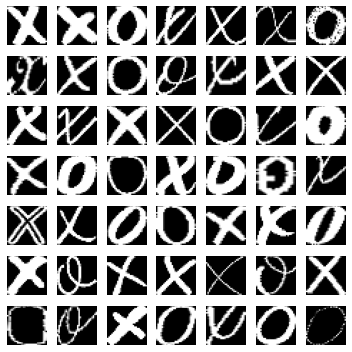

In [30]:
R,C = 7,7
fig,ax = plt.subplots(R,C,figsize=(5,5))
for label_class,plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im,label = data[ix]
        print()
        plot_cell.imshow(im[0].cpu(),cmap = 'gray')
plt.tight_layout()


## the model architecture, loss function, and the optimizer

In [31]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(3200, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid()

    ).to(device)


    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

### **train_batch**

In [32]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    is_correct = (prediction >0.5) ==y
    batch_loss = loss_fn(prediction,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(),is_correct[0]
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

# DataLoader

In [33]:
# the input is the dataset class.
train_dl = DataLoader(XO('/content/all/*'), batch_size=32, drop_last= True)

In [34]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [35]:
model, loss_fn, optimizer = get_model()

# **summary**

In [36]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            819,456
├─ReLU: 1-9                              --
├─Linear: 1-10                           257
├─Sigmoid: 1-11                          --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            819,456
├─ReLU: 1-9                              --
├─Linear: 1-10                           257
├─Sigmoid: 1-11                          --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0

In [37]:
for epoch in range(5):
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer,loss_fn)

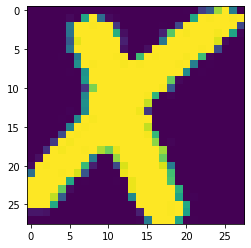

In [38]:
im,c = train_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

## **Intermediate_output**

In [39]:
#Pass the image through the trained model and fetch the output of the first layer.
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

# Plot the output of 64 filters

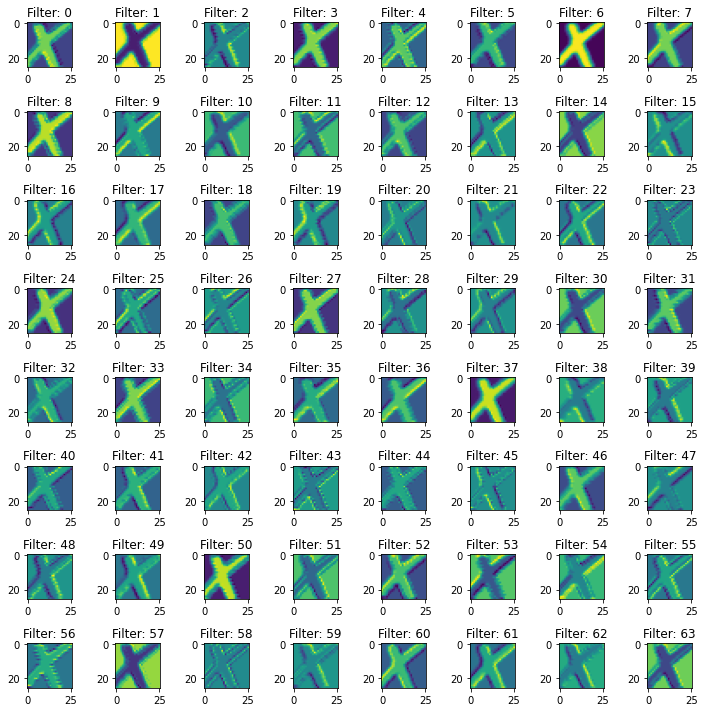

In [40]:
#Each channel in intermediate_output is the output of the convolution for each filter:
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

In [42]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3200, out_features=256, bias=True),
 ReLU(),
 Linear(in_features=256, out_features=1, bias=True),
 Sigmoid()]

In [43]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

In [44]:
second_intermediate_output.shape

torch.Size([128, 11, 11])

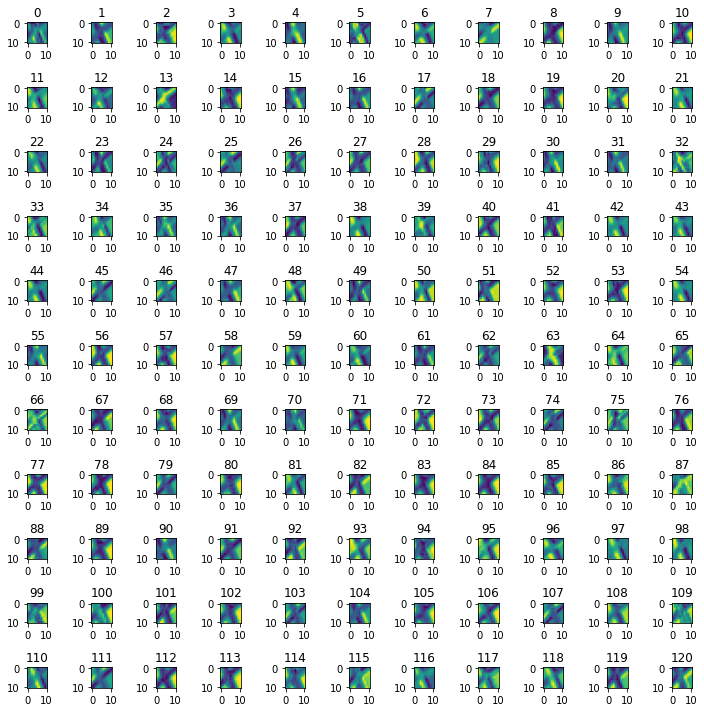

In [45]:
n = 11
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

# fetch multiple O images from the data

Pass multiple O images and inspect the output of the fourth filter across the images (we are only using the fourth filter for illustration purposes; you can choose a different filter if you wish):

In [47]:
x, y = next(iter(train_dl))
x2 = x[y==0]

Reshape x2 so that it has a proper input shape for a CNN model

In [48]:
x2 = x2.view(-1,1,28,28)

In [49]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

IndexError: ignored

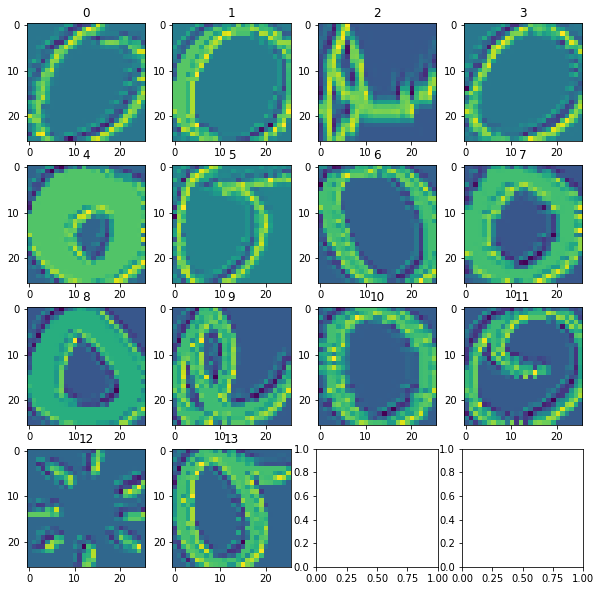

In [50]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix,4,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [51]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()

In [52]:
second_intermediate_output.shape

torch.Size([14, 128, 11, 11])

IndexError: ignored

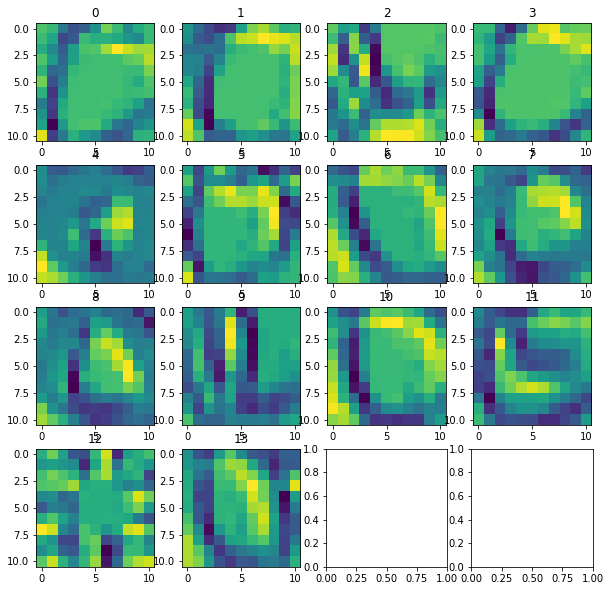

In [53]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [54]:
len(XO('/content/all/*'))

2498

In [55]:
custom_dl = DataLoader(XO('/content/all/*'), batch_size=2498, drop_last=True)

In [56]:
x, y = next(iter(custom_dl))

In [57]:
x2 = x[y==0]

In [58]:
len(x2)

1245

In [59]:
x2 = x2.view(len(x2),1,28,28)

In [60]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

In [61]:
flatten_layer_output.shape

torch.Size([1245, 3200])

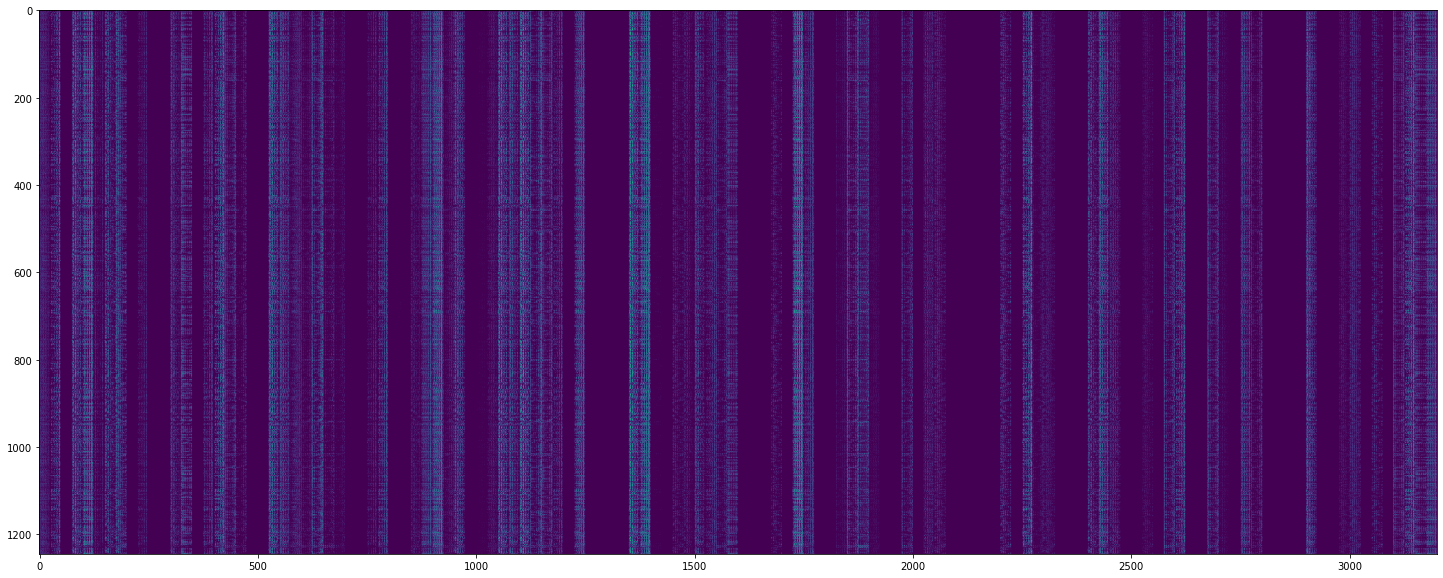

In [62]:
plt.figure(figsize=(100,10))
plt.imshow(flatten_layer_output.cpu())